In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
batch_size = 16
img_height = 256
img_width = 256
data_dir = '/content/drive/MyDrive/mirrordataset'

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 271 files belonging to 2 classes.
Using 217 files for training.
Found 271 files belonging to 2 classes.
Using 54 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['normal', 'ventriculomegaly']


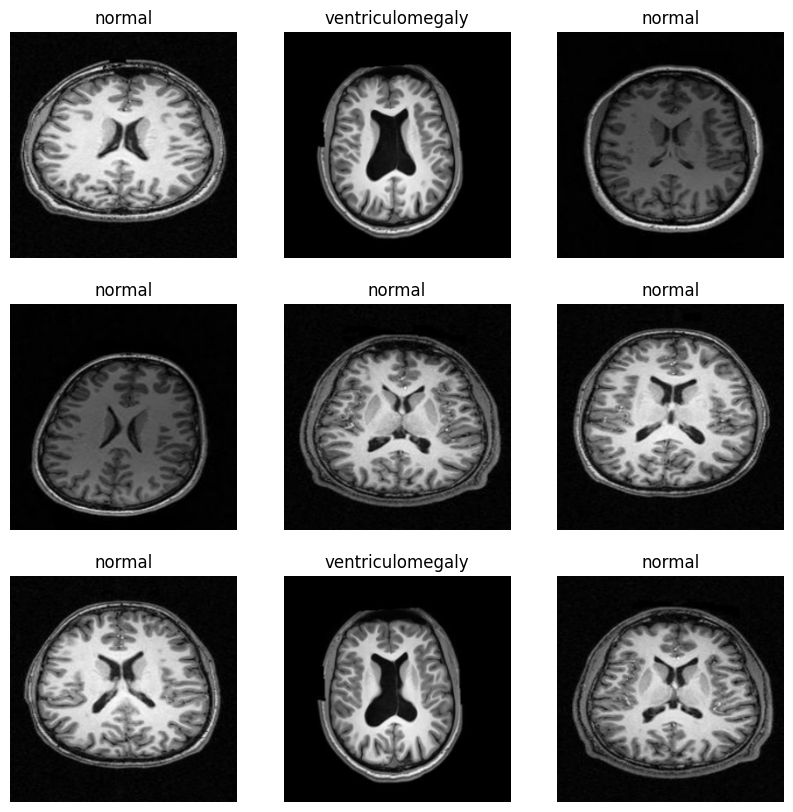

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

TRAINING AND TESTING

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 31s 2s/step - loss: 0.6907 - accuracy: 0.6959 - val_loss: 0.4190 - val_accuracy: 0.8704
Epoch 2/10
14/14 [==============================] - 18s 1s/step - loss: 0.3360 - accuracy: 0.8894 - val_loss: 0.2460 - val_accuracy: 0.9074
Epoch 3/10
14/14 [==============================] - 18s 1s/step - loss: 0.1326 - accuracy: 0.9493 - val_loss: 0.1754 - val_accuracy: 0.9074
Epoch 4/10
14/14 [==============================] - 18s 1s/step - loss: 0.0943 - accuracy: 0.9539 - val_loss: 0.2022 - val_accuracy: 0.9074
Epoch 5/10
14/14 [==============================] - 18s 1s/step - loss: 0.0542 - accuracy: 0.9724 - val_loss: 0.2556 - val_accuracy: 0.9259
Epoch 6/10
14/14 [==============================] - 20s 1s/step - loss: 0.0235 - accuracy: 0.9908 - val_loss: 0.1840 - val_accuracy: 0.9444
Epoch 7/10
14/14 [==============================] - 19s 1s/step - loss: 0.0246 - accuracy: 0.9954 - val_loss: 0.1180 - val_accuracy: 0.9444
Epoch 8/10
14/14 [==

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('fetal_img_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('fetal_img_model.h5') #Load Model

In [ ]:
def predict_new_images(img_paths,model):

  final_preds = []
  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in img_paths:

    ground_value = i.split('/')[5]

    img = tf.keras.utils.load_img(
      i, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = new_model.predict(img_array,verbose=0)
    score = tf.nn.softmax(predictions[0])

    print(
        "Actual - {} | Predicted - {} with a {:.2f} percent confidence."
        .format(ground_value,class_names[np.argmax(score)], 100 * np.max(score))
    )

    pred_title = "{}-{:.2f}".format(class_names[np.argmax(score)], 100 * np.max(score))

    ax = fig.add_subplot(1, len(img_paths), cnt+1)
    plt.imshow((plt.imread(i)), cmap='gray')
    plt.axis('off')
    plt.title(pred_title)
    cnt+=1

    tup = (f'{class_names[np.argmax(score)]}-{(100 * np.max(score)):.2f} %', img_array)
    final_preds.append(tup)


  return final_preds

In [ ]:
#Add Image Paths into the array for prediction

images_to_predict = [

    # Fetal Abdomen - 3 (num_feat)

    # '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-abdomen/Patient01789_Plane2_2_of_2.png',
    # '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-abdomen/Patient00960_Plane2_2_of_4.png',
    '/content/drive/MyDrive/img/image.0087.png',


    # Fetal Thorax - 8/5 (num_feat)

    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-thorax/Patient00811_Plane6_1_of_3.png',
    '/content/drive/MyDrive/img/image.0085.png',


    # Fetal Femur - 3 (num_feat)

    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-femur/Patient00168_Plane5_1_of_2.png',
    '/content/drive/MyDrive/img/image.0083.png',

    #Maternal Cervix - 8 (num_feat)

    '/content/drive/MyDrive/img/image.0091.png',
    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Maternal-cervix/Patient00239_Plane4_1_of_1.png',


    #Other

    '/content/drive/MyDrive/img/image.009.png',
    ##'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Other/Patient00002_Plane1_12_of_20.png',
    '/content/drive/MyDrive/img/image.0079.png'

]

final_preds = predict_new_images(images_to_predict,new_model)

LIME

In [ ]:
!pip install lime &> /dev/null

In [ ]:
import lime
from lime import lime_image
from lime import submodular_pick
from skimage.segmentation import mark_boundaries

In [ ]:
def explainer_predict_fn(img_array):
  return new_model.predict(img_array,verbose = 0)

In [ ]:
def lime_exp(img_array,model):

  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(img_array[0].numpy(),
                                 explainer_predict_fn,
                                 top_labels=5,
                                 hide_color=0,
                                 num_samples=1000)

  return exp

In [ ]:
def generate_prediction_sample(exp, exp_class, show_positive = True, hide_background = True):

    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=8,
                                         hide_rest=hide_background
                                        )
    img_boundry = mark_boundaries(image, mask)
    return img_boundry

In [ ]:
def show_images_to_pred(images_to_predict):

  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in images_to_predict:

    ax = fig.add_subplot(1, len(images_to_predict), cnt+1)
    ground = plt.imread(images_to_predict[cnt])
    plt.imshow(ground,cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(images_to_predict[cnt].split('/')[5])
    cnt+=1

In [ ]:
def get_explanations(final_preds,images_to_predict,model):

  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in final_preds:

    exp = lime_exp(i[1],model)
    img_boundry = generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

    ax = fig.add_subplot(1, len(final_preds), cnt+1)
    plt.imshow(img_boundry.astype('uint8'))
    plt.axis('off')
    plt.title(i[0])
    cnt+=1

  show_images_to_pred(images_to_predict)

In [ ]:
get_explanations(final_preds,images_to_predict,new_model)

GRADCAM

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_8"

# The local path to our target image
img_path =  '/content/drive/MyDrive/img/image.0091.png'
display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_img_array and make_gradcam_heatmap functions are correctly defined

img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = new_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
print("Predicted class index:", predicted_class)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_5"

# The local path to our target image
img_path =  '/content/drive/MyDrive/img/image.0086.png'
display(Image(img_path))

In [ ]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Assuming get_img_array and make_gradcam_heatmap functions are correctly defined

img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = new_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
print("Predicted class index:", predicted_class)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)